In [1]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.image import load_image
from torchlake.common.models import ResNetFeatureExtractor
from torchlake.image_classification.models.darknet19 import DarkNet19FeatureExtractor
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.object_detection.constants.schema import DetectorContext
from torchlake.common.datasets.voc import VOCDetectionFromCSV, VOCDetectionFromLMDB
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.object_detection.utils.train import collate_fn
from torchlake.object_detection.controller.trainer_yolov2 import YOLOV2Trainer
from torchlake.common.controller.recorder import TrainRecorder

from torchlake.object_detection.models.yolov2 import YOLOV2, YOLOV2Loss, PriorBox
from torchlake.object_detection.utils.plot import draw_pred
from torchlake.common.controller.weight_manager import WeightManager

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt

# setting

In [3]:
artifact_path = Path('../../artifacts/yolov2')
artifact_path.mkdir(exist_ok=True)

In [4]:
data_path = Path("../../data/VOCdevkit")

In [5]:
NUM_CLASS = len(VOC_CLASS_NAMES)
NUM_ANCHORS = 5

In [6]:
CONTEXT = DetectorContext(
    detector_name="yolov2",
    dataset="VOC",
    device="cuda:0",
    num_classes=NUM_CLASS,
    num_anchors=NUM_ANCHORS,
    anchors_path=artifact_path.joinpath("voc.anchors.416.txt").as_posix(),
)

# data

In [7]:
BATCH_SIZE = 64

In [8]:
IMAGE_SIZE = 416

In [9]:
transform = A.Compose(
    [
        A.ColorJitter(p=0.3),
        A.HorizontalFlip(),
        # A.ShiftScaleRotate(p=0.5, rotate_limit=0),
        A.RandomSizedBBoxSafeCrop(IMAGE_SIZE, IMAGE_SIZE, erosion_rate=0.1),
        # A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [10]:
train_dataset = VOCDetectionFromLMDB(
    data_path.joinpath("voc").as_posix(),
    transform=transform,
)

In [11]:
# train_dataset.env.close()

In [12]:
for x, y in train_dataset:
    print(x.shape, len(y))
    break

torch.Size([3, 416, 416]) 1


In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [14]:
for x, y in train_loader:
    # ...
    print(x.shape, len(y))
    break

torch.Size([64, 3, 416, 416]) 64


# model

If you don't have anchors yet, build one in debug section

In [15]:
backbone = ResNetFeatureExtractor("resnet34", "block", trainable=True)
backbone.fix_target_layers(["3_1", "4_1"])

In [16]:
# backbone = DarkNet19FeatureExtractor("last_conv", "../../artifacts/darknet19/darknet19_448.pth", trainable=True)
# backbone.fix_target_layers(["3_1", "4_1"])

In [17]:
model = YOLOV2(
    backbone,
    CONTEXT,
    passthrough_feature_dim=backbone.feature_dims[-2],
    neck_feature_dim=backbone.feature_dims[-1],
).to(CONTEXT.device)

In [18]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
YOLOV2                                             --
├─ResNetFeatureExtractor: 1-1                      --
│    └─ResNet: 2-1                                 --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    │    └─MaxPool2d: 3-4                         --
│    │    └─Module: 3-5                            221,952
│    │    └─Module: 3-6                            1,116,416
│    │    └─Module: 3-7                            6,822,400
│    │    └─Module: 3-8                            13,114,368
│    │    └─AdaptiveAvgPool2d: 3-9                 --
│    └─ImageNetNormalization: 2-2                  --
├─ModuleDict: 1-2                                  --
│    └─Sequential: 2-3                             --
│    │    └─Conv2dNormActivation: 3-10             8,256
│    │    └─StackedPatch2d: 3-11           

In [19]:
priorBox = PriorBox(CONTEXT)
anchors = priorBox.load_anchors()

# train

In [20]:
EPOCH = 100

In [21]:
trainer = YOLOV2Trainer(EPOCH, CONTEXT.device)

In [22]:
recorder = TrainRecorder(0, EPOCH, num_loss=5)
recorder.increment_data_size(len(train_dataset))

In [23]:
# underestimate the loss, since we drop last batch
recorder.data_size

16551

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = YOLOV2Loss(
    anchors,
    CONTEXT,
    prior_loss_threshold=BATCH_SIZE * 258, # one epoch
    return_all_loss=True,
)

In [25]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [26]:
scaler = torch.amp.GradScaler()

In [27]:
def validate_func(model):
    from torchlake.object_detection.models.yolov2.decode import Decoder
    from torchlake.object_detection.configs.schema import InferenceCfg
    from torchlake.object_detection.controller.predictor import Predictor
    from torchlake.object_detection.controller.evaluator import Evaluator
    
    decoder = Decoder(anchors.to("cpu"), CONTEXT)
    inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)
    
    predictor = Predictor(CONTEXT)
    predictor.set_postprocess_cfg(decoder, inferCfg)
    
    test_transform = A.Compose(
        [
            A.Resize(IMAGE_SIZE, IMAGE_SIZE),
            A.Normalize(0, 1),
            ToTensorV2(),
        ]
    )
    
    test_dataset = VOCDetectionFromCSV(
        data_path,
        data_path.joinpath("voc_test.csv"),
        transform=test_transform,
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        pin_memory=True,
        # num_workers=get_num_workers(),
        collate_fn=collate_fn,
    )
    
    evaluator = Evaluator(CONTEXT)
    
    result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES, verbose=False)
    
    print("validation mAP:", result_table['all'])

In [28]:
manager = WeightManager(artifact_path.joinpath("yolov2.{backbone_name}.{epoch}.pth").as_posix())
optimizer_manager = WeightManager(artifact_path.joinpath("adam.{lr}.{decay}.{epoch}.pth").as_posix())

In [29]:
def checkpoint_func(model: YOLOV2, optimizer: torch.optim.Optimizer):
    filename = manager.get_filename(
        backbone_name=model.foot.network_name,
        epoch=recorder.current_epoch,
    )
    manager.save_weight(model.state_dict(), filename)
    
    param_group = optimizer.param_groups[0]
    filename = optimizer_manager.get_filename(
        lr=param_group['lr'],
        decay=param_group['weight_decay'],
        epoch=recorder.current_epoch,
    )
    optimizer_manager.save_weight(optimizer.state_dict(), filename)

In [30]:
import random

def at_epoch_end_hook():
    random_size = random.randint(10, 19) * 32
    transform.transforms[2].height = random_size
    transform.transforms[2].width = random_size
    print(f"resize to {random_size}")

In [31]:
trainer.reset_seen()

In [32]:
training_loss = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler=scheduler,
    recorder=recorder,
    scaler=scaler,
    validate_func=validate_func,
    checkpoint_func=checkpoint_func,
    # at_epoch_end_hook=at_epoch_end_hook,
)

Enable AMP: True
Training...


100%|██████████| 258/258 [02:41<00:00,  1.59it/s]


------------------------------------
Epoch 1
------------------------------------
35.56839748555661 (0%)
1.8084514586343976 (0%)
29.721462694815386 (0%)
0.3823794674984272 (0%)
1.0071899984388664 (0%)


100%|██████████| 258/258 [02:35<00:00,  1.65it/s]


------------------------------------
Epoch 2
------------------------------------
6.398064077761181 (-82%)
1.4456311921311047 (-20%)
1.5911234934649345 (-95%)
0.5589332766103915 (46%)
0.5666430057135892 (-44%)


100%|██████████| 258/258 [02:35<00:00,  1.66it/s]


------------------------------------
Epoch 3
------------------------------------
4.84309740120115 (-24%)
1.0707502371450544 (-26%)
1.0853441796283487 (-32%)
0.4435737245241739 (-21%)
0.4691343658979213 (-17%)


100%|██████████| 258/258 [02:35<00:00,  1.65it/s]


------------------------------------
Epoch 4
------------------------------------
3.95558497106393 (-18%)
0.7812152339586588 (-27%)
0.8904750262291495 (-18%)
0.37779763492383484 (-15%)
0.3949065303220525 (-16%)


100%|██████████| 258/258 [02:35<00:00,  1.66it/s]


------------------------------------
Epoch 5
------------------------------------
3.3556548830721153 (-15%)
0.586954218463576 (-25%)
0.775050314868169 (-13%)
0.33196757139522054 (-12%)
0.33381247697629346 (-15%)


100%|██████████| 258/258 [02:35<00:00,  1.66it/s]


------------------------------------
Epoch 6
------------------------------------
3.0554277172161255 (-9%)
0.48420821376512685 (-18%)
0.68823547552276 (-11%)
0.30593452738257787 (-8%)
0.3533113978145476 (6%)


100%|██████████| 258/258 [02:35<00:00,  1.66it/s]


------------------------------------
Epoch 7
------------------------------------
2.7789798211305214 (-9%)
0.4256858054723388 (-12%)
0.6356081991107523 (-8%)
0.2832903497550835 (-7%)
0.30123407413906056 (-15%)


100%|██████████| 258/258 [02:35<00:00,  1.66it/s]


------------------------------------
Epoch 8
------------------------------------
2.57059649269888 (-7%)
0.37936058082463014 (-11%)
0.5927224627406016 (-7%)
0.2642147799329335 (-7%)
0.27743955649866325 (-8%)


100%|██████████| 258/258 [02:35<00:00,  1.66it/s]


------------------------------------
Epoch 9
------------------------------------
2.420699087242858 (-6%)
0.34258847360228945 (-10%)
0.5525359926493999 (-7%)
0.24921523476718738 (-6%)
0.2794984506988849 (1%)


100%|██████████| 258/258 [02:35<00:00,  1.66it/s]


------------------------------------
Epoch 10
------------------------------------
2.2883662392701156 (-5%)
0.304817364097873 (-11%)
0.5218381673704424 (-6%)
0.23226110167852246 (-7%)
0.3004051843126567 (7%)
Validating...


100%|██████████| 78/78 [01:06<00:00,  1.17it/s]


validation mAP: AP@0.5    0.537503
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.10.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.0.0001.1e-05.10.pth, model size is 352.58MiB


100%|██████████| 258/258 [02:37<00:00,  1.64it/s]


------------------------------------
Epoch 11
------------------------------------
2.5523336937287646 (12%)
0.4384968872697222 (44%)
0.5249440014149861 (1%)
0.26298983145621563 (13%)
0.2739436485120431 (-9%)


100%|██████████| 258/258 [03:49<00:00,  1.13it/s]


------------------------------------
Epoch 12
------------------------------------
2.392339126414514 (-6%)
0.37864042199937886 (-14%)
0.5037929782564349 (-4%)
0.24313010106914448 (-8%)
0.29425521240040775 (7%)


100%|██████████| 258/258 [03:55<00:00,  1.10it/s]


------------------------------------
Epoch 13
------------------------------------
2.20119836376366 (-8%)
0.3460736373826229 (-9%)
0.48192428437671403 (-4%)
0.2277788051369903 (-6%)
0.23430640666796396 (-20%)


100%|██████████| 258/258 [03:54<00:00,  1.10it/s]


------------------------------------
Epoch 14
------------------------------------
1.786025220566621 (-19%)
0.22788289015217203 (-34%)
0.3916120276221491 (-19%)
0.18522540914076768 (-19%)
0.240403262447154 (3%)


100%|██████████| 258/258 [03:53<00:00,  1.11it/s]


------------------------------------
Epoch 15
------------------------------------
1.6498809094429299 (-8%)
0.1967050567234214 (-14%)
0.36673954210067605 (-6%)
0.17293289220410168 (-7%)
0.2217718466452823 (-8%)


100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


------------------------------------
Epoch 16
------------------------------------
1.666314396625717 (1%)
0.18677037577997566 (-5%)
0.35603721036225866 (-3%)
0.16753089124720932 (-3%)
0.2858523682059641 (29%)


100%|██████████| 258/258 [03:51<00:00,  1.12it/s]


------------------------------------
Epoch 17
------------------------------------
1.522895551391918 (-9%)
0.1766548077078155 (-5%)
0.34817342848642646 (-2%)
0.16114460473391623 (-4%)
0.19234428883434382 (-33%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 18
------------------------------------
1.5028053439496807 (-1%)
0.1710273366731846 (-3%)
0.33764826011876686 (-3%)
0.15753296804344558 (-2%)
0.20646490176907695 (7%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 19
------------------------------------
1.4823082596663224 (-1%)
0.16811713053952398 (-2%)
0.33367617029011815 (-1%)
0.1543417122131978 (-2%)
0.2088063942558506 (1%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 20
------------------------------------
1.4758566738320194 (0%)
0.15950930446276496 (-5%)
0.32996639016387486 (-1%)
0.15294338481230768 (-1%)
0.2216640608050399 (6%)
Validating...


100%|██████████| 78/78 [01:17<00:00,  1.00it/s]


validation mAP: AP@0.5    0.600453
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.20.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0000000000000002e-06.1e-05.20.pth, model size is 352.58MiB


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 21
------------------------------------
1.3958865653120927 (-5%)
0.1526778984535109 (-4%)
0.3145971644516043 (-5%)
0.14872789498175254 (-3%)
0.18497203815437852 (-17%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 22
------------------------------------
1.3537362053577122 (-3%)
0.1490923045200277 (-2%)
0.31139005326006064 (-1%)
0.14634900380892227 (-2%)
0.16150882364968783 (-13%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 23
------------------------------------
1.3524388736284407 (0%)
0.14601224963020107 (-2%)
0.30882019605112837 (-1%)
0.1453741955170854 (-1%)
0.1707354543951082 (6%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 24
------------------------------------
1.3770358763420436 (2%)
0.14580874444206607 (0%)
0.31181099989444333 (1%)
0.1456761069473821 (0%)
0.19103559355211153 (12%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 25
------------------------------------
1.3537397886516749 (-2%)
0.14749057877352556 (1%)
0.3107117765310359 (0%)
0.14413944332774375 (-1%)
0.17484022173577016 (-8%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 26
------------------------------------
1.3850258642881994 (2%)
0.14935012700932102 (1%)
0.31328704567317434 (1%)
0.14451918334919456 (0%)
0.1997927811979693 (14%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 27
------------------------------------
1.336617715999328 (-3%)
0.14681779640360934 (-2%)
0.3092246930567953 (-1%)
0.14278956079301527 (-1%)
0.1666274191454367 (-17%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 28
------------------------------------
1.3222227633003012 (-1%)
0.15028215272139514 (2%)
0.3086448349294961 (0%)
0.14444934754967725 (1%)
0.14104903785060666 (-15%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 29
------------------------------------
1.3350525656017849 (1%)
0.14867543420088083 (-1%)
0.30639772597817616 (-1%)
0.14537520045910302 (1%)
0.153103402068439 (9%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 30
------------------------------------
1.3968809398738482 (5%)
0.1468816195346172 (-1%)
0.30660650522843874 (0%)
0.145216383146639 (0%)
0.21731089439343695 (42%)
Validating...


100%|██████████| 78/78 [01:17<00:00,  1.01it/s]


validation mAP: AP@0.5    0.605985
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.30.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0000000000000004e-08.1e-05.30.pth, model size is 352.58MiB


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 31
------------------------------------
1.367952277772585 (-2%)
0.14468224854867173 (-1%)
0.30772177701010545 (0%)
0.14413310951224628 (-1%)
0.194882701137737 (-10%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 32
------------------------------------
1.3901070279085732 (2%)
0.1455499482481841 (1%)
0.3062176840102647 (0%)
0.14452222097849868 (0%)
0.21572829561934787 (11%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 33
------------------------------------
1.3447361874022898 (-3%)
0.1466498907062843 (1%)
0.3077644385943478 (1%)
0.1453932215530602 (1%)
0.1633557421542693 (-24%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 34
------------------------------------
1.3642060839512582 (1%)
0.14633526737816313 (0%)
0.30938168878850875 (1%)
0.14658587510892182 (1%)
0.17555975775712643 (7%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 35
------------------------------------
1.3497280927303932 (-1%)
0.14705328166063483 (0%)
0.30933413172220503 (0%)
0.14463102328482738 (-1%)
0.17018556360045733 (-3%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 36
------------------------------------
1.3615992944065256 (1%)
0.14558832756767587 (-1%)
0.3078624724074149 (0%)
0.1446860632171272 (0%)
0.18471817075431934 (9%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 37
------------------------------------
1.3773694739342595 (1%)
0.14738877240527212 (1%)
0.30787060350228274 (0%)
0.1448174873570086 (0%)
0.198022662185195 (7%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 38
------------------------------------
1.3898211401918148 (1%)
0.14579136631912457 (-1%)
0.3072309216864701 (0%)
0.1438541377493208 (-1%)
0.21752817117514595 (10%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 39
------------------------------------
1.3718789260658664 (-1%)
0.14651437972825163 (0%)
0.3061466739657539 (0%)
0.14558338088993858 (1%)
0.19130097492303982 (-12%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 40
------------------------------------
1.3665132124426427 (0%)
0.14340149525839518 (-2%)
0.30717953367396333 (0%)
0.14426367134927207 (-1%)
0.19461382192381554 (2%)
Validating...


100%|██████████| 78/78 [01:17<00:00,  1.01it/s]


validation mAP: AP@0.5    0.605928
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.40.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0000000000000004e-08.1e-05.40.pth, model size is 352.58MiB


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 41
------------------------------------
1.3976236485936515 (2%)
0.1447054636989084 (1%)
0.30768167526727275 (0%)
0.14465912268115824 (0%)
0.2219408971003898 (14%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 42
------------------------------------
1.3807432633225316 (-1%)
0.1459997687107284 (1%)
0.3098435148098889 (1%)
0.14553618030629917 (1%)
0.19721907482040046 (-11%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 43
------------------------------------
1.3947553422024495 (1%)
0.14452321880440372 (-1%)
0.30891844006321106 (0%)
0.14509403556504286 (0%)
0.21584349764444244 (9%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 44
------------------------------------
1.3712386377383101 (-2%)
0.14514851707697957 (0%)
0.30322968305097203 (-2%)
0.14395584290023725 (-1%)
0.20308122043702986 (-6%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 45
------------------------------------
1.3565357215857843 (-1%)
0.14653932530385463 (1%)
0.30808902505617974 (2%)
0.14520468068521888 (1%)
0.1758839643568396 (-13%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 46
------------------------------------
1.384313771101104 (2%)
0.1467308448553877 (0%)
0.3085902761270702 (0%)
0.14509874651795188 (0%)
0.20349891107540877 (16%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 47
------------------------------------
1.38660054025056 (0%)
0.14879503200640593 (1%)
0.30933768614837615 (0%)
0.1459381664046333 (1%)
0.19877698712316944 (-2%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 48
------------------------------------
1.4032040498572296 (1%)
0.14666896070298047 (-1%)
0.3096371209842546 (0%)
0.14555505288489223 (0%)
0.21912270430373054 (10%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 49
------------------------------------
1.3977813587023915 (0%)
0.14512532702760528 (-1%)
0.3062318618992912 (-1%)
0.1415843392317335 (-3%)
0.23850247487007156 (9%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 50
------------------------------------
1.366552603553771 (-2%)
0.1487001865682669 (2%)
0.3057593374509884 (0%)
0.1443914085938113 (2%)
0.19013603073139954 (-20%)
Validating...


100%|██████████| 78/78 [01:18<00:00,  1.01s/it]


validation mAP: AP@0.5    0.605613
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.50.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0000000000000004e-08.1e-05.50.pth, model size is 352.58MiB


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 51
------------------------------------
1.3323725774766286 (-3%)
0.147434786477987 (-1%)
0.3083394102859798 (1%)
0.14330179633262197 (-1%)
0.16008939726332092 (-16%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 52
------------------------------------
1.3946988293212914 (5%)
0.14440611763437253 (-2%)
0.30942707189684737 (0%)
0.1448123483713729 (1%)
0.2168038961397731 (35%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 53
------------------------------------
1.3567227834978455 (-3%)
0.14540254181659115 (1%)
0.30990577140219466 (0%)
0.14234792152622822 (-2%)
0.18967486238862794 (-13%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 54
------------------------------------
1.3293772843746783 (-2%)
0.1462547698702872 (1%)
0.3081332070684439 (-1%)
0.1450285500438903 (2%)
0.14984656511048283 (-21%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 55
------------------------------------
1.399717803765161 (5%)
0.1472230205492098 (1%)
0.3091696699496357 (0%)
0.1468517536425848 (1%)
0.20906634728617982 (40%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 56
------------------------------------
1.3360668440742671 (-5%)
0.14430660023429115 (-2%)
0.3072852747842673 (-1%)
0.1447208245336005 (-1%)
0.1608708515447271 (-23%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 57
------------------------------------
1.3657481387319694 (2%)
0.14450904700152636 (0%)
0.3106417167036203 (1%)
0.14468041372964716 (0%)
0.18719530962693445 (16%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 58
------------------------------------
1.3318931948821002 (-2%)
0.14650666933392156 (1%)
0.30683985425441923 (-1%)
0.14330802532230852 (-1%)
0.16200654566176356 (-13%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 59
------------------------------------
1.3611693883272071 (2%)
0.1434571948788129 (-2%)
0.3126194352189201 (2%)
0.14458915024939975 (1%)
0.18214701116715268 (12%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 60
------------------------------------
1.3533334384604996 (-1%)
0.1474894076832457 (3%)
0.3082469009962707 (-1%)
0.14302157912036248 (-1%)
0.18248923390547345 (0%)
Validating...


100%|██████████| 78/78 [01:16<00:00,  1.02it/s]


validation mAP: AP@0.5    0.609209
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.60.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0000000000000004e-08.1e-05.60.pth, model size is 352.58MiB


100%|██████████| 258/258 [03:51<00:00,  1.12it/s]


------------------------------------
Epoch 61
------------------------------------
1.3580844508766823 (0%)
0.1453473176216332 (-1%)
0.3127188866653153 (1%)
0.14498760540185324 (1%)
0.1750802160584237 (-4%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 62
------------------------------------
1.366639456772876 (1%)
0.14131194207972395 (-3%)
0.3116481468818834 (0%)
0.14424590068773582 (-1%)
0.19244986346506812 (10%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 63
------------------------------------
1.368354436429445 (0%)
0.14400351326254285 (2%)
0.3063888312985071 (-2%)
0.14575837705871594 (1%)
0.1891702008559966 (-2%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 64
------------------------------------
1.3448288568189348 (-2%)
0.14352374265982032 (0%)
0.30778091253884854 (0%)
0.14318070998833446 (-2%)
0.1776206531263062 (-6%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 65
------------------------------------
1.3480432664913744 (0%)
0.1472700754254039 (3%)
0.3112598114608314 (1%)
0.14499444712627968 (1%)
0.16454114749578397 (-7%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 66
------------------------------------
1.3990358070667166 (4%)
0.1464012050749665 (-1%)
0.3102838185955542 (0%)
0.14317077533347852 (-1%)
0.22649690857265486 (38%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 67
------------------------------------
1.367566070731806 (-2%)
0.1460110549443899 (0%)
0.30761361976352947 (-1%)
0.1458651908725621 (2%)
0.1846154407679614 (-18%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 68
------------------------------------
1.3897392490062674 (2%)
0.14735833738989765 (1%)
0.3092234227010675 (1%)
0.14504428091643268 (-1%)
0.20793608391539195 (13%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 69
------------------------------------
1.3398191232953822 (-4%)
0.1457844029869618 (-1%)
0.3098477567043859 (0%)
0.14346006293864658 (-1%)
0.1668866506826264 (-20%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 70
------------------------------------
1.3348200866430024 (0%)
0.14359406931264465 (-2%)
0.30911510279226007 (0%)
0.14445867732056514 (1%)
0.1598175355771698 (-4%)
Validating...


100%|██████████| 78/78 [01:17<00:00,  1.00it/s]


validation mAP: AP@0.5    0.609305
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.70.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0000000000000004e-08.1e-05.70.pth, model size is 352.58MiB


100%|██████████| 258/258 [03:51<00:00,  1.12it/s]


------------------------------------
Epoch 71
------------------------------------
1.3599728426467435 (2%)
0.14343837136034165 (0%)
0.30687669583817817 (-1%)
0.14393010881903462 (0%)
0.1900072250904385 (19%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 72
------------------------------------
1.4023458865623615 (3%)
0.14731557037483053 (3%)
0.30414650201235693 (-1%)
0.1440516019197371 (0%)
0.23062580676606317 (21%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 73
------------------------------------
1.3331790239773056 (-5%)
0.14418732756956423 (-2%)
0.3102459687710123 (2%)
0.1446870023711168 (0%)
0.15531072094536835 (-33%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 74
------------------------------------
1.390160816038896 (4%)
0.1465334144072779 (2%)
0.3066766038343458 (-1%)
0.1451721116499802 (0%)
0.21109023977785216 (36%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 75
------------------------------------
1.3741141097955163 (-1%)
0.1461338685701335 (0%)
0.3103458952395251 (1%)
0.143013389022262 (-1%)
0.20256740223942957 (-4%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 76
------------------------------------
1.3793563780543465 (0%)
0.1440514177651169 (-1%)
0.30947585518169574 (0%)
0.14517713395441903 (2%)
0.19994343527781852 (-1%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 77
------------------------------------
1.3325171176490227 (-3%)
0.14392244238902716 (0%)
0.30761705814232737 (-1%)
0.1440010691083788 (-1%)
0.16097228152968998 (-19%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 78
------------------------------------
1.355684077226174 (2%)
0.14721701609159937 (2%)
0.3059662315364506 (-1%)
0.14352840104136808 (0%)
0.18485882299399128 (15%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 79
------------------------------------
1.3545090633464008 (0%)
0.1462451575436366 (-1%)
0.31018118575709624 (1%)
0.14525525486798424 (1%)
0.17180644023181457 (-7%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 80
------------------------------------
1.3429830854345715 (-1%)
0.144208784161302 (-1%)
0.30780888093532677 (-1%)
0.14447650456527922 (-1%)
0.168582902085161 (-2%)
Validating...


100%|██████████| 78/78 [01:16<00:00,  1.01it/s]


validation mAP: AP@0.5    0.609268
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.80.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0000000000000004e-08.1e-05.80.pth, model size is 352.58MiB


100%|██████████| 258/258 [03:51<00:00,  1.12it/s]


------------------------------------
Epoch 81
------------------------------------
1.3777185891461257 (3%)
0.14770975295715585 (2%)
0.3066340194613647 (0%)
0.14463344185555868 (0%)
0.2002076096465872 (19%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 82
------------------------------------
1.3800271712835506 (0%)
0.14480791867056633 (-2%)
0.30936533325381554 (1%)
0.14567289795517444 (1%)
0.19748942454872043 (-1%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 83
------------------------------------
1.3817063721636118 (0%)
0.14323483336462325 (-1%)
0.30862673534222523 (0%)
0.14341135490596796 (-2%)
0.2127880283903336 (8%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 84
------------------------------------
1.3295300967541632 (-4%)
0.14513532667820941 (1%)
0.3097576470139106 (0%)
0.14286508840215528 (0%)
0.16031168517112201 (-25%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 85
------------------------------------
1.40874028535748 (6%)
0.146075196622268 (1%)
0.3072293317106925 (-1%)
0.1446043499343944 (1%)
0.23241401339548182 (45%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 86
------------------------------------
1.3733611430410793 (-3%)
0.14524731521670975 (-1%)
0.3110358430845025 (1%)
0.1446541436784081 (0%)
0.19380727525016953 (-17%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 87
------------------------------------
1.3541129479112386 (-1%)
0.14601630574230356 (1%)
0.30842580138992354 (-1%)
0.14367548866679927 (-1%)
0.18129339359885696 (-6%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 88
------------------------------------
1.3902171581333553 (3%)
0.14355997140080143 (-2%)
0.3138482401100331 (2%)
0.14401236511589097 (0%)
0.2127471275541634 (17%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 89
------------------------------------
1.362924714901176 (-2%)
0.14622270560366854 (2%)
0.30652418776758694 (-2%)
0.1450412233216792 (1%)
0.18497170620357567 (-13%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 90
------------------------------------
1.3652354988271926 (0%)
0.1449539785651338 (-1%)
0.31214197276474237 (2%)
0.14483398999644087 (0%)
0.18396959485737444 (-1%)
Validating...


100%|██████████| 78/78 [01:16<00:00,  1.02it/s]


validation mAP: AP@0.5    0.609308
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.90.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0000000000000004e-08.1e-05.90.pth, model size is 352.58MiB


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 91
------------------------------------
1.313736865401059 (-4%)
0.1444687910306405 (0%)
0.30769063822704934 (-1%)
0.14348493110131705 (-1%)
0.1441527825238503 (-22%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 92
------------------------------------
1.33633626850629 (2%)
0.1427332881238697 (-1%)
0.3086733300911609 (0%)
0.1454272021714903 (1%)
0.1577936421347617 (9%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 93
------------------------------------
1.3621802727309364 (2%)
0.1438227213946623 (1%)
0.31039084002990497 (1%)
0.14548116398393535 (0%)
0.18056089207813625 (14%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 94
------------------------------------
1.355069293045838 (-1%)
0.14591278429010043 (1%)
0.3099566766714576 (0%)
0.14366076384546622 (-1%)
0.18089601599005492 (0%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 95
------------------------------------
1.379686284948278 (2%)
0.14516457791242288 (-1%)
0.30687724058091204 (-1%)
0.14520708434668614 (1%)
0.20160904900702542 (11%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 96
------------------------------------
1.3484674658518057 (-2%)
0.14649098899442103 (1%)
0.3077315730448181 (0%)
0.14457550732205388 (0%)
0.17136736617953485 (-15%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 97
------------------------------------
1.3672462003799046 (1%)
0.14737812525325286 (1%)
0.30739126354681 (0%)
0.14401661195133283 (0%)
0.19239375306201426 (12%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 98
------------------------------------
1.4039778078756968 (3%)
0.1457975685513636 (-1%)
0.3108097726603979 (1%)
0.14493493107278346 (1%)
0.22269580797964442 (16%)


100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


------------------------------------
Epoch 99
------------------------------------
1.380494851877622 (-2%)
0.14810035214468206 (2%)
0.31119524573323293 (0%)
0.14250452621747606 (-2%)
0.20867662501546905 (-6%)


100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


------------------------------------
Epoch 100
------------------------------------
1.370679166783567 (-1%)
0.14299612223623046 (-3%)
0.3079605785916344 (-1%)
0.1451314997078105 (2%)
0.1940649677911819 (-7%)
Validating...


100%|██████████| 78/78 [01:18<00:00,  1.00s/it]


validation mAP: AP@0.5    0.609707
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.100.pth, model size is 176.41MiB
Save weight to ..\..\artifacts\yolov2\adam.1.0000000000000004e-08.1e-05.100.pth, model size is 352.58MiB


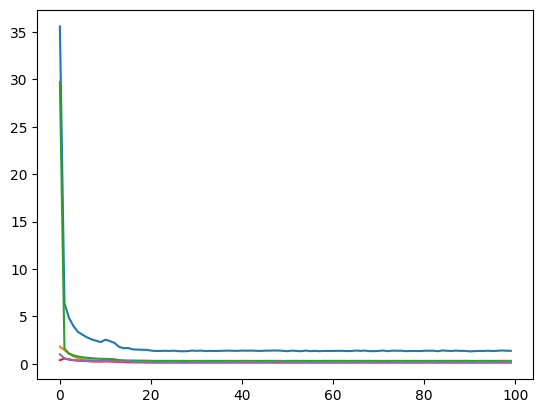

In [33]:
plt.plot(torch.Tensor(recorder.training_losses).T)

# load

In [34]:
manager = WeightManager(artifact_path.joinpath("{detector_name}.{backbone_name}.{epoch}.pth").as_posix())

In [37]:
model_path = manager.get_filename(
    detector_name=CONTEXT.detector_name,
    backbone_name=backbone.network_name,
    # epoch=recorder.current_epoch,
    epoch=30,
)

In [36]:
model_path

WindowsPath('../../artifacts/yolov2/yolov2.resnet34.10.pth')

In [ ]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\yolov2\yolov2.resnet34.10.prior.pth, model size is 176.41MiB


In [ ]:
manager.load_weight(model_path, model)

# Inference

In [54]:
from tqdm import tqdm
from torchlake.object_detection.models.yolov2.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor

In [55]:
decoder = Decoder(anchors.to("cpu"), CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)

In [56]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [57]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    # bbox_params=A.BboxParams(
    #     format="yolo",
    #     # min_area=1024,
    #     # min_visibility=0.3,
    # ),
)

In [58]:
import numpy as np
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import rand_color_map, plot_grids

In [59]:
color_map = rand_color_map(VOC_CLASS_NAMES)

In [60]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [61]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [62]:
model.eval()
with torch.no_grad():
    for img, _ in tqdm(test_loader):
        img = img.to(CONTEXT.device)

        # B x (?, 25)
        output = predictor.detect_image(model, img, is_batch=True)
        break

  0%|          | 0/77 [00:01<?, ?it/s]


In [ ]:
# model.eval()
# with torch.no_grad():
#     output = model(img)
#     decoded = decoder.decode(output.cpu(), (IMAGE_SIZE, IMAGE_SIZE))
#     boxes = decoded[4]
#     # boxes = output[0].unflatten(0, (5, 25)).permute(0, 2, 3, 1).reshape(-1, 25)
#     print(boxes[boxes[:, 4] > 0.1])

In [ ]:
# boxes[169*1:169*2, 4]

In [63]:
placeholder = []
for im, o in zip(img, output):
    overlay = img_tensor_to_np(im, 255, np.uint8)
    draw_pred(
        overlay,
        o,
        class_names=VOC_CLASS_NAMES,
        class_colors=color_map,
    )
    placeholder.append(overlay)

dog: 0.79
horse: 0.34
horse: 0.81
person: 0.69
person: 0.36
bicycle: 0.88
person: 0.85
car: 0.89
person: 0.31
person: 0.43
person: 0.46
cow: 0.43
person: 0.90
chair: 0.35
pottedplant: 0.43
sofa: 0.93
car: 0.54
car: 0.67
car: 0.87
dog: 0.94
car: 0.31
car: 0.52
car: 0.41
car: 0.61
car: 0.52
car: 0.49
car: 0.58
car: 0.38
dog: 0.76
dog: 0.61
motorbike: 0.52
motorbike: 0.85
person: 0.84
person: 0.38
person: 0.64
bus: 0.90
car: 0.52
car: 0.49
car: 0.60
motorbike: 0.88
person: 0.87
dog: 0.92
motorbike: 0.78
motorbike: 0.93
car: 0.55
horse: 0.37
cow: 0.39
sheep: 0.31
sheep: 0.77
bottle: 0.67
bottle: 0.67
bottle: 0.66
bottle: 0.33
person: 0.82
car: 0.82
car: 0.82
tvmonitor: 0.86
person: 0.78
tvmonitor: 0.71
boat: 0.55
person: 0.63
person: 0.49
person: 0.57
person: 0.63
person: 0.37
person: 0.57
person: 0.71
person: 0.67
person: 0.47
person: 0.63
person: 0.49
diningtable: 0.47
person: 0.78
person: 0.31
person: 0.61
person: 0.44
person: 0.85
person: 0.87
person: 0.85
horse: 0.70
horse: 0.33
horse

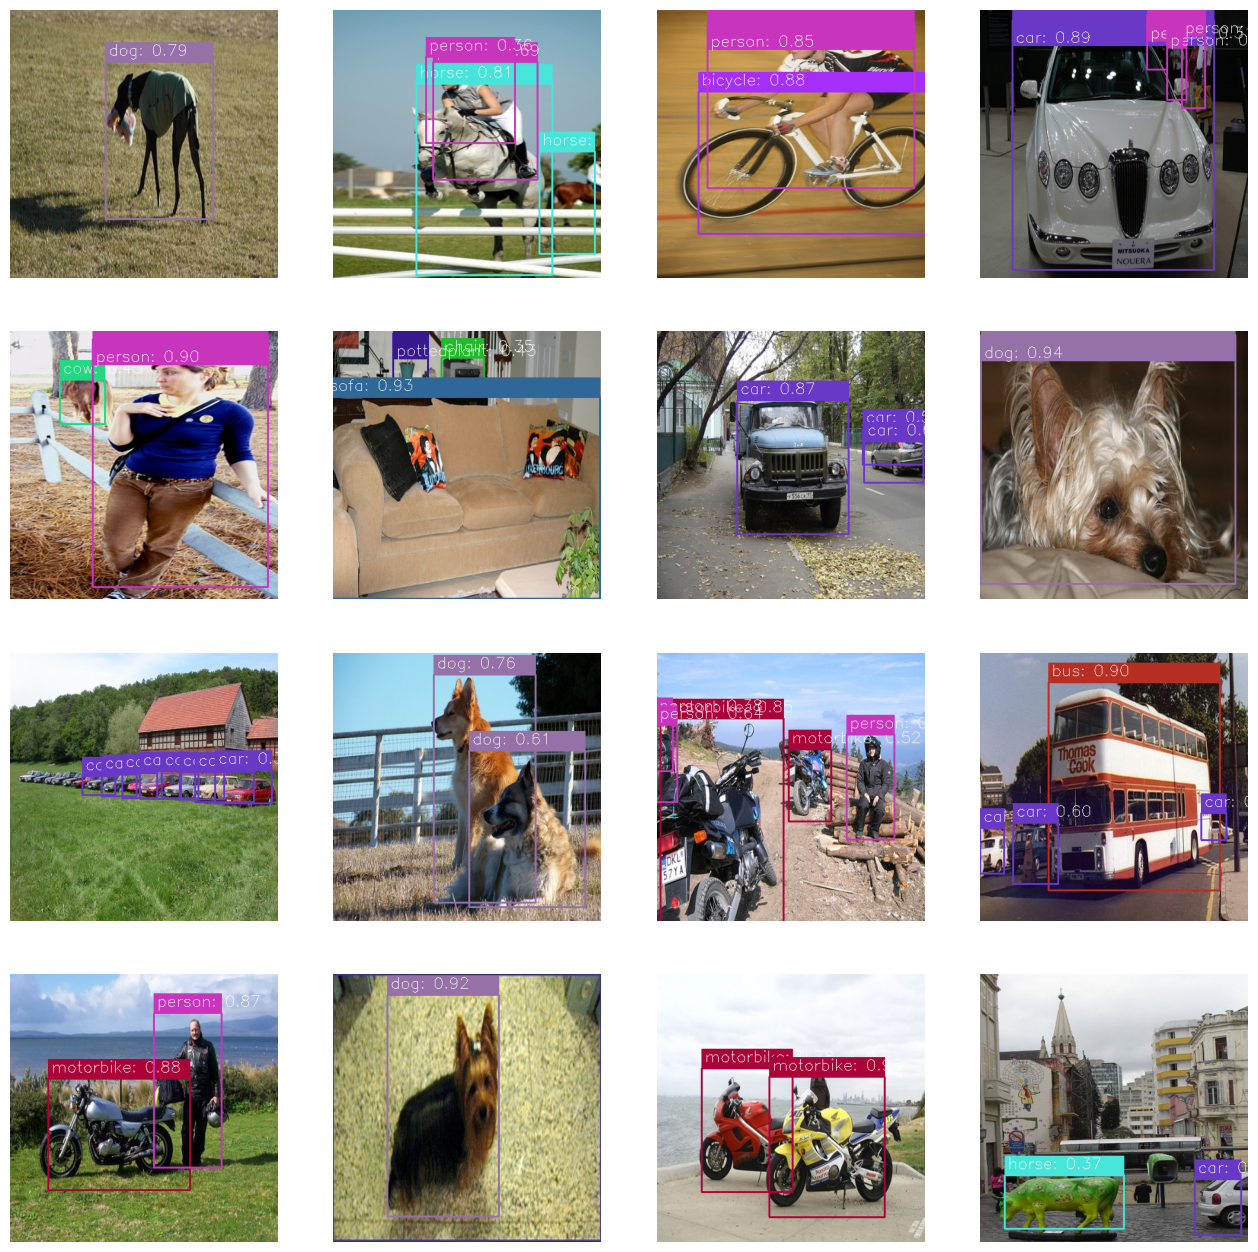

In [64]:
plot_grids(
    placeholder[:16],
    num_row=4,
    num_col=4,
    figsize=(16,16),
)

In [65]:
humans_img = "D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg"
human_img = "D://W/hmm/Screenshot_20240612_091521.jpg"
obj_img = "D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"

predictor.predict_image_file(
    model,
    [humans_img, human_img, obj_img],
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 0.89
person: 0.92
D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg 2
person: 0.82
D://W/hmm/Screenshot_20240612_091521.jpg 1
aeroplane: 0.83
D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg 1


In [ ]:
predictor.predict_video_file(
    model,
    "../../data/movie.mp4",
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

# evaluate

In [38]:
from torchlake.object_detection.models.yolov2.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor
from torchlake.object_detection.controller.evaluator import Evaluator

In [39]:
VAL_IMAGE_SIZE = 416

In [47]:
decoder = Decoder(anchors.to("cpu"), CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)

In [48]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [49]:
test_transform = A.Compose(
    [
        A.Resize(VAL_IMAGE_SIZE, VAL_IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [50]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [51]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    # shuffle=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [52]:
evaluator = Evaluator(CONTEXT)

In [ ]:
# conf 0.3
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 78/78 [01:20<00:00,  1.03s/it]


       aeroplane   bicycle      bird      boat    bottle       bus       car  \
AP@0.5  0.617145  0.620677  0.619579  0.608716  0.518531  0.589029  0.602404   

             cat     chair       cow  ...       dog     horse motorbike  \
AP@0.5  0.610531  0.596317  0.595648  ...  0.608233  0.676019  0.680355   

         person pottedplant     sheep      sofa     train tvmonitor       all  
AP@0.5  0.61219    0.607668  0.606943  0.607292  0.608811   0.60879  0.609707  

[1 rows x 21 columns]


In [ ]:
# conf 0.1
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 78/78 [01:21<00:00,  1.04s/it]


       aeroplane  bicycle      bird      boat    bottle      bus       car  \
AP@0.5  0.683317  0.69545  0.674431  0.648512  0.550433  0.56738  0.631551   

             cat     chair       cow  ...       dog     horse motorbike  \
AP@0.5  0.650156  0.631368  0.630651  ...  0.659601  0.668583  0.672588   

          person pottedplant     sheep      sofa    train tvmonitor       all  
AP@0.5  0.654696    0.645438  0.646222  0.647711  0.65344   0.65334  0.645356  

[1 rows x 21 columns]


In [ ]:
result_table.T

,AP@0.5
aeroplane,0.683317
bicycle,0.69545
bird,0.674431
boat,0.648512
bottle,0.550433
bus,0.56738
car,0.631551
cat,0.650156
chair,0.631368
cow,0.630651


# further evaluation

# debug

## draw anchors

In [ ]:
VAL_IMAGE_SIZE = 416

In [ ]:
test_transform = A.Compose(
    [
        A.Resize(VAL_IMAGE_SIZE, VAL_IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [ ]:
train_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_trainval.csv"),
    transform=test_transform,
)

In [ ]:
if not (Path(CONTEXT.anchors_path).exists() and Path(CONTEXT.anchors_path).is_file()):
    p = PriorBox(CONTEXT)
    anchors = p.build_anchors(train_dataset.table[["w", "h"]].to_numpy())
    p.save_anchors(anchors)

gt shape:  torch.Size([40058, 2])
init evaluation score: 0.5776740074157715
new evaluation score: 0.6373701095581055
new evaluation score: 0.6394929051399231
final mean IOU:  0.6394929051399231
member count of each group:  [4494, 11716, 6708, 6689, 10451]


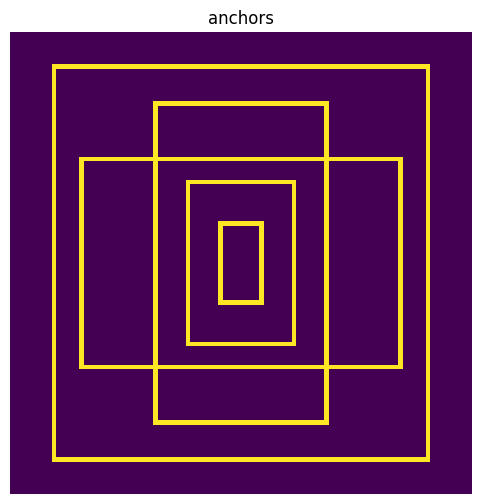

In [ ]:
from torchlake.object_detection.utils.plot import draw_anchors
from torchlake.object_detection.models.yolov2 import PriorBox
from torchlake.object_detection.utils.config import load_anchors
from torchlake.common.utils.plot import plot_grids

box = PriorBox(CONTEXT)
anchors = load_anchors(CONTEXT.anchors_path)

canvas = [draw_anchors(anchors)]

plot_grids(
    canvas,
    ["anchors"],
    1,
    1,
    figsize=(8,6),
)

In [ ]:
from copy import deepcopy

CONTEXT_FOR_ANCHORS = deepcopy(CONTEXT)
CONTEXT_FOR_ANCHORS.anchors_path = artifact_path.joinpath("voc.anchors.416.txt")

In [ ]:
wh = []
for _, labels in train_dataset:
    wh.extend(labels)

wh = torch.Tensor(wh)[:, 2:4]

In [ ]:
if not (Path(CONTEXT_FOR_ANCHORS.anchors_path).exists() and Path(CONTEXT_FOR_ANCHORS.anchors_path).is_file()):
    p = PriorBox(CONTEXT_FOR_ANCHORS)
    anchors = p.build_anchors(wh)
    p.save_anchors(anchors)

gt shape:  torch.Size([40058, 2])
init evaluation score: 0.5904454588890076
new evaluation score: 0.6173481583595276
new evaluation score: 0.6272975206375122
final mean IOU:  0.6272975206375122
member count of each group:  [8892, 6324, 14151, 5986, 4705]


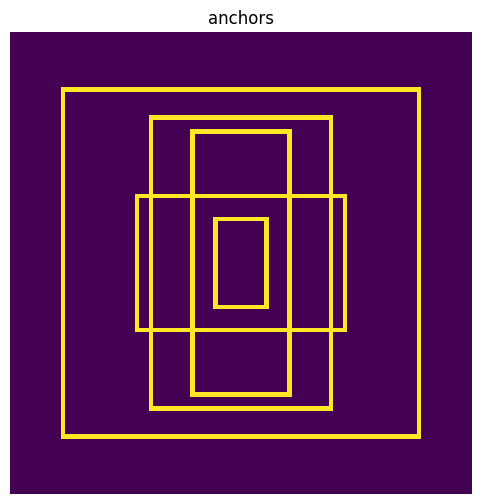

In [ ]:
from torchlake.object_detection.utils.plot import draw_anchors
from torchlake.object_detection.models.yolov2 import PriorBox
from torchlake.object_detection.utils.config import load_anchors
from torchlake.common.utils.plot import plot_grids

box = PriorBox(CONTEXT_FOR_ANCHORS)
anchors = box.load_anchors()

canvas = [draw_anchors(anchors[0, :, :, 0, 0])]

plot_grids(
    canvas,
    ["anchors"],
    1,
    1,
    figsize=(8,6),
)

## match

In [ ]:
from torchlake.object_detection.utils.train import build_flatten_targets
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.object_detection.utils.plot import draw_label
from torchlake.object_detection.utils.train import generate_grid_train

In [ ]:
criterion = YOLOV2Loss(anchors, CONTEXT)

In [ ]:
for x, y in train_loader:
    break

In [ ]:
t, span = build_flatten_targets(y, (13, 13), delta_coord=True)

In [ ]:
batch_idx = 6

In [ ]:
cloned_image = img_tensor_to_np(x[batch_idx])

In [ ]:
model.eval()
with torch.no_grad():
    output = model(x.to(CONTEXT.device))
    output = output.unflatten(1, (5, 25))
    output[:, :, :2, :, :] = output[:, :, :2, :, :].sigmoid()
    output[:, :, 4, :, :] = output[:, :, 4, :, :].sigmoid()
    output[:, :, 5:, :, :] = output[:, :, 5:, :, :].softmax(2)

In [ ]:
output.shape

torch.Size([64, 5, 25, 13, 13])

In [ ]:
matched, positivity = criterion.match(t.to(CONTEXT.device), span, output, 13, 13)
matched, positivity = [m.to("cpu") for m in matched], positivity.to("cpu")

In [ ]:
matched[batch_idx], span[batch_idx], positivity[batch_idx]

(tensor([[ 1.2205e-02,  2.1231e-02,  1.4878e-01, -4.6301e-01,  1.8000e+01,
           0.0000e+00,  5.1160e+03]]),
 1,
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
# iou
matched[batch_idx][:, 5].long()

tensor([0])

In [ ]:
# best box indices
matched[batch_idx][:, 6].long()

tensor([5116])

In [ ]:
positivity.shape

torch.Size([64, 845])

In [ ]:
# check if positivity correct
positivity.view(-1)[matched[batch_idx][:, 6].long()].eq(1).all().item()

True

In [ ]:
positivity.view(-1)[matched[batch_idx][:, 6].long()].eq(2).sum()

tensor(0)

In [ ]:
# candidate index among A*H*W
# candidates = torch.arange(845).to(CONTEXT.device)[positivity.long()[0:sum(span[:1])]]
candidates = matched[batch_idx][:, 6].long() % 845

In [ ]:
anchors_no, cells_no = candidates // (13 * 13), candidates % (13*13)
cells_h, cells_w = cells_no // 13, cells_no % 13
anchors_no, cells_no, cells_h, cells_w

(tensor([0]), tensor([46]), tensor([3]), tensor([7]))

In [ ]:
# anchor matched target
# matched_gts =  matched[0, matched[0, :, 6], :]
matched_gts = matched[batch_idx]

In [ ]:
# anchors_cxcy = generate_grid_train(13, 13, center=True).permute(0, 1, 3, 4, 2).reshape(-1, 2).repeat(CONTEXT.num_anchors, 1).to(CONTEXT.device)
anchors_cxcy = torch.cat([(cells_w[:, None] + 0.5) / 13, (cells_h[:, None] + 0.5) / 13], 1)

In [ ]:
matched_anchors = anchors.to("cpu")[:, anchors_no].permute(0, 1, 3, 4, 2).reshape(-1, 2)

In [ ]:
matched_anchors

tensor([[0.7698, 0.7563]])

In [ ]:
matched_anchors = torch.cat([anchors_cxcy, matched_anchors], 1)

In [ ]:
# anchors_cxcy = anchors_cxcy[(anchors_no*13**2+cells_no).long()]
# anchors_xy = anchors_cxcy - matched_anchors / 2
# matched_anchors = torch.cat([anchors_xy, matched_anchors], -1)

In [ ]:
matched_anchors

tensor([[0.5769, 0.2692, 0.7698, 0.7563]])

In [ ]:
matched_gts

tensor([[ 1.2205e-02,  2.1231e-02,  1.4878e-01, -4.6301e-01,  1.8000e+01,
          0.0000e+00,  5.1160e+03]])

In [ ]:
matched_gts[:, 2:4] = matched_gts[:, 2:4].exp() * matched_anchors[:, 2:4]
matched_gts[:, :2] = matched_gts[:, :2] + (matched_anchors[:, :2] - 0.5 /13) - matched_gts[:, 2:4]/2 

In [ ]:
# x,y, w,h,c,iou,best_prior_idx
matched_gts

tensor([[1.0400e-01, 1.4000e-02, 8.9333e-01, 4.7600e-01, 1.8000e+01, 0.0000e+00,
         5.1160e+03]])

In [ ]:
num_gt = len(matched_gts)
draw_label(
    cloned_image,
    torch.cat([matched_gts[:, :4], torch.zeros(num_gt, 1).to("cpu")], 1),
    class_names=["gt", "anchor"],
    class_colors={"gt": (0, 128, 128), "anchor": (128, 0, 0)},
    class_show=False,
)

In [ ]:
matched_anchors[:, :2] = matched_anchors[:, :2] - matched_anchors[:, 2:4] / 2

In [ ]:
num_gt = len(matched_gts)
draw_label(
    cloned_image,
    torch.cat([matched_anchors[:, :4], torch.ones(num_gt, 1).to("cpu")], 1),
    class_names=["gt", "anchor"],
    class_colors={"gt": (0, 128, 128), "anchor": (128, 0, 0)},
    class_show=False,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].


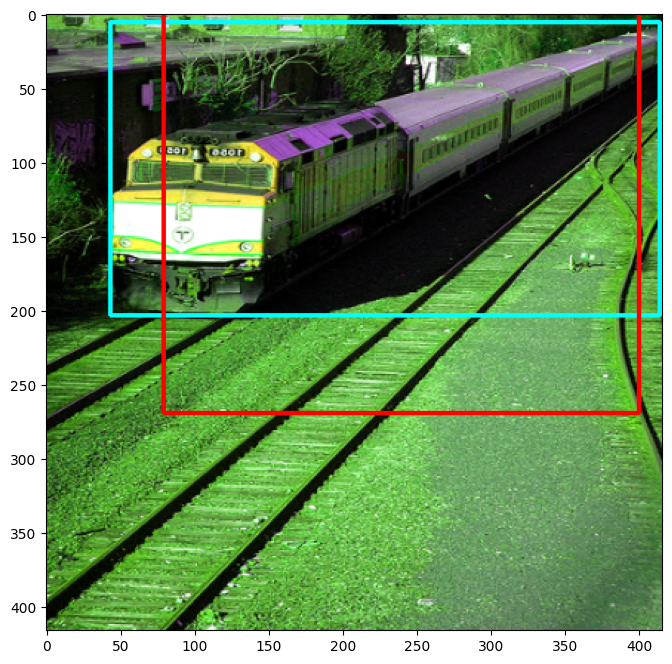

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(cloned_image)